## Fly Cell Atlas 10X Genomics Testis Male Germline Analysis

In [ ]:
processx::run("wget", "https://cloud.flycellatlas.org/index.php/s/kR9W49Qj9FoeyT8/download/testis.h5ad")

In [5]:
library(callr)
library(dplyr)
library(Matrix)
library(reticulate)
library(Seurat)
library(stringr)

Conversion

In [7]:
gtf <- read.table("dmel-all-r6.31.gtf.gz", sep="\t", quote="")
rowData <- with(
  subset(gtf, V3 == "gene"),
  tibble(
    rowname = str_extract(V9, "gene_symbol \"([^\"]+)\"", group=1),
    flybaseid = str_extract(V9, "gene_id \"([^\"]+)\"", group=1),
    chr = V1,
    start = V4,
    end = V5,
    strand = V7,
  )
)
write.csv(rowData, "dmel-all-r6.31-rowData.csv", row.names = F)

In [6]:
rowData <- read.csv("dmel-all-r6.31-rowData.csv")

In [9]:
Ypath <- r(
  \() {
    library(dplyr)
    library(Matrix)
    library(reticulate)
    use_virtualenv("r-reticulate")
    anndata <- import("anndata", convert=FALSE)
    builtins <- import("builtins", convert=FALSE)
    numpy <- import("numpy", convert=FALSE)
    ann <- anndata$read_h5ad("testis.h5ad")
    Y <- sparseMatrix(
      i = 1 + py_to_r(ann$X$indices$tolist()),
      p = py_to_r(ann$X$indptr$tolist()),
      x = py_to_r(ann$X$data$astype(builtins$int)$tolist())
    )
    Y <- as.matrix(Y)
    rownames(Y) <- py_to_r(ann$var$index$values$tolist())
    colnames(Y) <- py_to_r(ann$obs$index$values$tolist())
    rowData <- read.csv("dmel-all-r6.31-rowData.csv")
    Y <- Y[match(rowData$rowname, rownames(Y)), ]
    Y[is.na(Y)] <- 0
    rownames(Y) <- rowData$rowname
    Y <- as(Y, "sparseMatrix")
    output_path <- "testis-counts.rds"
    saveRDS(Y, output_path)
    output_path
  }
)

In [7]:
Ypath <- "testis-counts.rds"

In [4]:
colData <- r(
  \() {
    library(dplyr)
    library(forcats)
    library(MatrixGenerics)
    library(reticulate)
    library(scuttle)
    library(Seurat)
    library(stringr)
    use_virtualenv("r-reticulate")
    anndata <- import("anndata", convert=FALSE)
    builtins <- import("builtins", convert=FALSE)
    numpy <- import("numpy", convert=FALSE)
    ann <- anndata$read_h5ad("testis.h5ad")
    Y <- readRDS("testis-counts.rds")
    rowData <- read.csv("dmel-all-r6.31-rowData.csv")
    colData <- tibble(
      rowname = py_to_r(ann$obs$index$values$tolist()),
      as_tibble(
        CreateSeuratObject(counts = Y)@meta.data
      ),
      ident = factor(
        py_to_r(ann$obs$annotation$tolist())
      ) %>%
        fct_relevel(
          c(
            "spermatogonium",
            "mid-late proliferating spermatogonia",
            "spermatogonium-spermatocyte transition",
            "spermatocyte 0",
            "spermatocyte 1",
            "spermatocyte 2",
            "spermatocyte 3",
            "spermatocyte 4",
            "spermatocyte 5",
            "spermatocyte 6",
            "spermatocyte 7a",
            "late primary spermatocyte",
            "early elongation stage spermatid",
            "early-mid elongation-stage spermatid",
            "mid-late elongation-stage spermatid",
            "cyst stem cell",
            "early cyst cell 1",
            "early cyst cell 2",
            "cyst cell intermedate",
            "spermatocyte cyst cell branch a",
            "spermatocyte cyst cell branch b",
            "cyst cell branch a",
            "cyst cell branch b",
            "late cyst cell branch a",
            "late cyst cell branch b",
            "adult fat body",
            "muscle cell"
          )
        ),
      technology = py_to_r(ann$obs$technology$tolist()) %>% factor(),
      batch = factor(
        str_extract(rowname, "sample[123]"),
        c("sample1", "sample2", "sample3", "ss2")
      ) %>%
        replace(technology == "ss2", "ss2"),
      pctMito = colSums2(
        Y[rowData$chr == "mitochondrion_genome", ]
      ) /
        colSums2(Y) *
        100,
      as_tibble(
        CreateSeuratObject(Y) %>%
          PercentageFeatureSet("^Rp[SL]", col.name = "pctRibo") %>%
          FetchData("pctRibo")
      ),
      size_factor = pooledSizeFactors(
        Y,
        clusters = ident
      ),
    )
    saveRDS(colData, "testis-colData.rds")
    colData
  }
)
print(colData, width=180)

# A tibble: 43,828 × 10
   rowname                                                               
   <chr>                                                                 
 1 AAACCCACACGGCGTT-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
 2 AAACCCACATTACTCT-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
 3 AAACCCAGTACGGCAA-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
 4 AAACCCAGTCGTAATC-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
 5 AAACCCAGTCGTATGT-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
 6 AAACCCAGTGCGACAA-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
 7 AAACCCATCGCACTCT-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
 8 AAACCCATCTCCACTG-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
 9 AAACGAAAGCATTTGC-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
10 AAACGAAAGCGGTATG-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
   orig.ident    nCount_RNA nFeature_RNA ident                              
   <fct>   

In [8]:
colData <- readRDS("testis-colData.rds")

In [12]:
percentageExpression <- r(
  function() {
    library(dplyr)
    library(Matrix)
    library(tibble)
    counts <- readRDS("testis-counts.rds")
    colData <- readRDS("testis-colData.rds")
    celltype_counts <- table(colData$ident)
    data <- tibble(
      gene = 1+counts@i,
      cell = rep(seq(ncol(counts)), diff(counts@p)),
      celltype = colData$ident[cell],
    ) %>%
      group_by(gene, celltype) %>%
      tally()
    result <- sparseMatrix(
      i = data$gene,
      j = as.numeric(data$celltype),
      x = data$n,
      dims = c(nrow(counts), length(celltype_counts)),
      dimnames = list(
        rownames(counts),
        names(celltype_counts)
      )
    ) %>%
      as.matrix()
    result <- result / rep(celltype_counts, each=nrow(counts))
    write.csv(result %>% as.data.frame() %>% rownames_to_column("symbol"), "testis-percentExpression.csv", row.names=F)
    result <- result
  },
  show=T
)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Seurat Workflow

The features to use (per biological replicate) will be the union of 3000 Seurat Variable Features (Log Normalized), and 2000 Seurat Variable Features (Log Normalized) on the "spermatogonium" cluster's within-variance alone. In the Fly Cell Atlas, there is a rare cell type "germline stem cell" that all seem to be contained by the single cluster labeled "spermatogonium", so this within-cluster variance is highly meaningful to us.

Next, the final features are determined by Seurat (total 5000) by first prioritizing features that appear in all 3 replicates' variable features list, then in descending order of priority, features that appear in 2 or 1 of the lists of 5000 features. The "integrated" assay is only calculated for the var features list that is determined in advance. We will use the "integrated" assay for PCA and for SPCA.

In [ ]:
var.features <- r(
  function() {
    library(dplyr)
    library(Seurat)
    library(tibble)
    library(withr)
    tenx <- CreateSeuratObject(
      readRDS("testis-counts.rds"),
      meta.data = column_to_rownames(readRDS("testis-colData.rds"))
    )
    tenx[["RNA"]]@meta.features <- read.csv("dmel-all-r6.31-rowData.csv") %>%
      column_to_rownames()
    tenx <- tenx %>% subset(technology == "10x")
    tenx$batch <- tenx$batch %>%
      factor(c("sample1", "sample2", "sample3")) %>%
      `contrasts<-`(value = contr.sum(3))

    set.seed(0)
    Idents(tenx) <- tenx$ident
    tenx <- tenx %>%
      SplitObject("batch") %>%
      lapply(
        \(x) x %>%
          NormalizeData(verb = F) %>%
          FindVariableFeatures(nfeatures = 2000, verb = F) %>%
          `VariableFeatures<-`(
            value = union(
              VariableFeatures(.),
              subset(
                .,
                ident = "spermatogonium"
              ) %>%
                FindVariableFeatures(nfeatures = 2000, verb = F) %>%
                VariableFeatures()
            )
          )
      ) %>%
      SelectIntegrationFeatures(
        nfeatures = 2000
      )
  },
  show = TRUE
)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Attaching SeuratObject


In [ ]:
# Genes of interest, including GSC (nos, vas), SG (Mst87F, Amph, Hsromega), and other (tj).
sapply(
  c("nos", "vas", "Mst87F", "Amph", "Hsromega", "tj"),
  \(n) head(grep(n, var.features, val=T), 1)
)

$nos
[1] "nos"

$vas
character(0)

$Mst87F
character(0)

$Amph
[1] "Amph"

$Hsromega
[1] "lncRNA:Hsromega"

$tj
[1] "tj"

In [1]:
library(callr)
tenx <- r(
  function() {
    library(dplyr)
    library(Seurat)
    library(tibble)
    tenx <- CreateSeuratObject(
      readRDS("testis-counts.rds"),
      meta.data = column_to_rownames(readRDS("testis-colData.rds"))
    )
    tenx[["RNA"]]@meta.features <- read.csv("dmel-all-r6.31-rowData.csv") %>%
      column_to_rownames()
    tenx <- tenx %>% subset(technology == "10x")
    tenx$batch <- tenx$batch %>%
      factor(c("sample1", "sample2", "sample3")) %>%
      `contrasts<-`(value = contr.sum(3))

    percentageExpression <- read.csv("testis-percentExpression.csv")
    spermatogoniumFeatures <- percentageExpression$symbol[percentageExpression$spermatogonium >= 0.25]
    set.seed(0)
    Idents(tenx) <- tenx$ident
    tenx <- tenx %>%
      SplitObject("batch") %>%
      lapply(
        \(x) x %>%
          NormalizeData(verb = F) %>%
          FindVariableFeatures(nfeatures = 3000, verb = F) %>%
          `VariableFeatures<-`(
            value = union(
              VariableFeatures(.),
              subset(
                .,
                ident = "spermatogonium"
              ) %>%
                FindVariableFeatures(nfeatures = 2000, verb = F) %>%
                VariableFeatures()
            )
          )
      ) %>%
      FindIntegrationAnchors(dims = 1:25, anchor.features = 5000) %>%
      IntegrateData(dims = 1:25)
    saveRDS(tenx[["integrated"]], "testis-integrated.rds")
    tenx
  },
  show = TRUE
)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Attaching SeuratObject
Computing 5000 integration features
Scaling features for provided objects
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 29664 anchors
Filtering anchors
	Retained 15122 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 30291 anchors
Filtering anchors
	Retained 15331 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 29582 anchors
Filtering anchors
	Retained 14989 anchors
Merging dataset 2 into 1
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Inte

In [ ]:
scale.data <- r(
  function() {
    library(dplyr)
    library(Seurat)
    library(tibble)
    library(withr)
    tenx <- CreateSeuratObject(
      readRDS("testis-counts.rds"),
      meta.data = column_to_rownames(readRDS("testis-colData.rds"))
    )
    tenx[["RNA"]]@meta.features <- read.csv("dmel-all-r6.31-rowData.csv") %>%
      column_to_rownames()
    tenx <- tenx %>% subset(technology == "10x")
    tenx$batch <- tenx$batch %>%
      factor(c("sample1", "sample2", "sample3")) %>%
      `contrasts<-`(value = contr.sum(3))

    set.seed(0)
    tenx <- tenx %>%
      SplitObject("batch") %>%
      lapply(
        \(x) x %>%
          NormalizeData(verb = F) %>%
          FindVariableFeatures(nfeatures = 2000, verb = F)
      )
    var.features <- SelectIntegrationFeatures(
      object.list = tenx,
      nfeatures = 3000
    )
    var.features <- var.features[
      order(match(var.features, rownames(tenx[[1]])))
    ]
    tenx <- CreateSeuratObject(
      readRDS("testis-counts.rds"),
      assay = "RNA"
    )
    integrated <- readRDS("testis-integrated.rds")
    tenx <- tenx[, Cells(integrated)]
    tenx[["integrated"]] <- integrated
    DefaultAssay(tenx) <- "integrated"
    VariableFeatures(tenx) <- rownames(integrated)
    tenx$logFeature <- log(tenx$nFeature_RNA) / log(10)
    tenx <- tenx %>%
      ScaleData(
        features = var.features,
        vars.to.regress = c("logFeature", "pctMito")
      )
    scale.data <- tenx[["integrated"]]@scale.data
    saveRDS(scale.data, "testis-scale.data.rds")
    scale.data
  },
  show = TRUE
)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Attaching SeuratObject
Regressing out logFeature
  |======================================================================| 100%
Centering and scaling data matrix
  |======================================================================| 100%


In [12]:
scale.data <- r(
  function() {
    library(callr)
    library(dplyr)
    library(Seurat)
    library(tibble)
    library(withr)
    tenx <- CreateSeuratObject(
      readRDS("testis-integrated.rds"),
      assay = "integrated",
      meta.data = column_to_rownames(readRDS("testis-colData.rds")) %>%
        subset(batch %in% c("sample1", "sample2", "sample3"))
    )
    tenx <- tenx %>%
      AddMetaData(
        r(
          function() {
            library(dplyr)
            library(Seurat)
            library(tibble)
            readRDS("testis-counts.rds") %>%
              CreateSeuratObject(
                meta.data = column_to_rownames(readRDS("testis-colData.rds"))
              ) %>%
              subset(batch %in% c("sample1", "sample2", "sample3")) %>%
              FetchData("nFeature_RNA") %>%
              within(logFeature <- log(nFeature_RNA) / log(10))
          }
        )
      )
    tenx$batch <- tenx$batch %>%
      factor(c("sample1", "sample2", "sample3")) %>%
      `contrasts<-`(value = contr.sum(3))
    VariableFeatures(tenx) <- rownames(tenx)

    tenx <- tenx %>%
      ScaleData(
        vars.to.regress = c("logFeature", "pctMito")
      )
    scale.data <- tenx[["integrated"]]@scale.data
    saveRDS(scale.data, "testis-scale.data.rds")
    scale.data
  },
  show = TRUE
)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Attaching SeuratObject
Regressing out logFeature, pctMito
  |======================================================================| 100%
Centering and scaling data matrix
  |======================================================================| 100%


Now load the results, run PCA, and run UMAP.

In [1]:
library(dplyr)
library(Matrix)
library(Seurat)
library(tibble)
library(withr)
write.table(Sys.time(), stderr())
tenx <- CreateSeuratObject(
  readRDS("testis-counts.rds"),
  meta.data = column_to_rownames(readRDS("testis-colData.rds"))
)
tenx[["RNA"]]@meta.features <- read.csv("dmel-all-r6.31-rowData.csv") %>%
  column_to_rownames()
tenx <- tenx %>% subset(technology == "10x")
tenx$batch <- tenx$batch %>%
  factor(c("sample1", "sample2", "sample3")) %>%
  `contrasts<-`(value = contr.sum(3))
Idents(tenx) <- tenx$ident

tenx[["integrated"]] <- readRDS("testis-integrated.rds")
DefaultAssay(tenx) <- "integrated"
tenx[["integrated"]]@scale.data <- readRDS("testis-scale.data.rds")
tenx <- with_seed(
    0,
    tenx %>%
        RunPCA() %>%
        RunUMAP(dims = 1:15)
)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject

PC_ 1 
Positive:  lncRNA:Hsromega, shep, CG9932, mgl, mtgo, luna, Gmap, pyd, Eip75B, caps 
	   Pdp1, shot, ed, Eip93F, par-1, RapGAP1, cv-c, CG43658, Samuel, tai 
	   bun, jvl, Pde11, Atpalpha, nuf, kek5, Rbp6, CG42663, mamo, SNF4Agamma 
Negative:  lncRNA:CR43264, Pzl, Myo81F, side-VI, bru1, asRNA:CR44370, kl-3, Ppr-Y, CG44774, lovit 
	   CG40470, salto, WDY, Fkbp12, lncRNA:CR43803, bru3, Snap25, soti, SteXh:CG42398, kl-2 
	   CG34434, twi, CG43291, CG14183, dac, CG3491, DIP-lambda, CG31740, CG15040, Mst84Da 
PC_ 2 
Positive:  retn, Lim1, CG18628, NAAT1, NT5E-2, CG15117, CG9664, Hex-A, CG33970, unc-13-4A 
	   bbg, CG15096, Idgf4, CG10960, dpr10, CG15822, CG7778, 5-HT2A, tim, fus 
	   Drip, CG10407, MFS9, Kank, lncRNA:CR43684, CG42237, CG14507, Clk, CG6959, GlcAT-P 

SPCA proceeds using the 2 clusters that are labeled as spermatogonia (they are not yet expressing the complex transcriptional programs in the spermatocytes prior to meiosis). If we include more of the germline connected component (the rectangular inset shown below), then SPC1 won't necessarily mark the GSCs specifically.

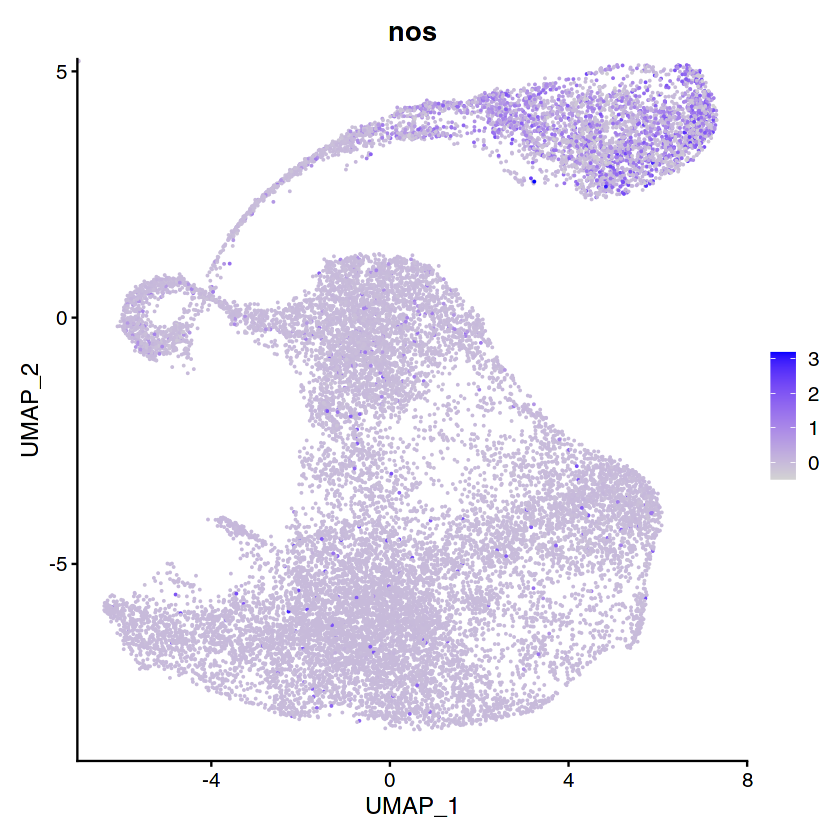

In [2]:
library(ggplot2)
xmin <- -7
xmax <- 8
ymin <- -9
ymax <- 5.25
FeaturePlot(tenx, "nos") + coord_cartesian(c(xmin, xmax), c(ymin, ymax), ex=F)

In [3]:
FetchData(tenx, c("UMAP_1", "UMAP_2", "ident")) %>%
  subset(between(UMAP_1, -10, 0) & between(UMAP_2, -8, 0)) %>%
  pull(ident) %>%
  droplevels() %>%
  table() %>%
  sort(dec=T)

.
             early elongation stage spermatid 
                                         4378 
                                 spermatocyte 
                                         1723 
                              spermatocyte 7a 
                                          346 
                                    spermatid 
                                          297 
                                 pigment cell 
                                          204 
                               spermatocyte 4 
                                          139 
                                      unknown 
                                          118 
                               adult fat body 
                                           82 
secretory cell of the male reproductive tract 
                                           75 
         early-mid elongation-stage spermatid 
                                           51 
                               spermatocyte 6 
           

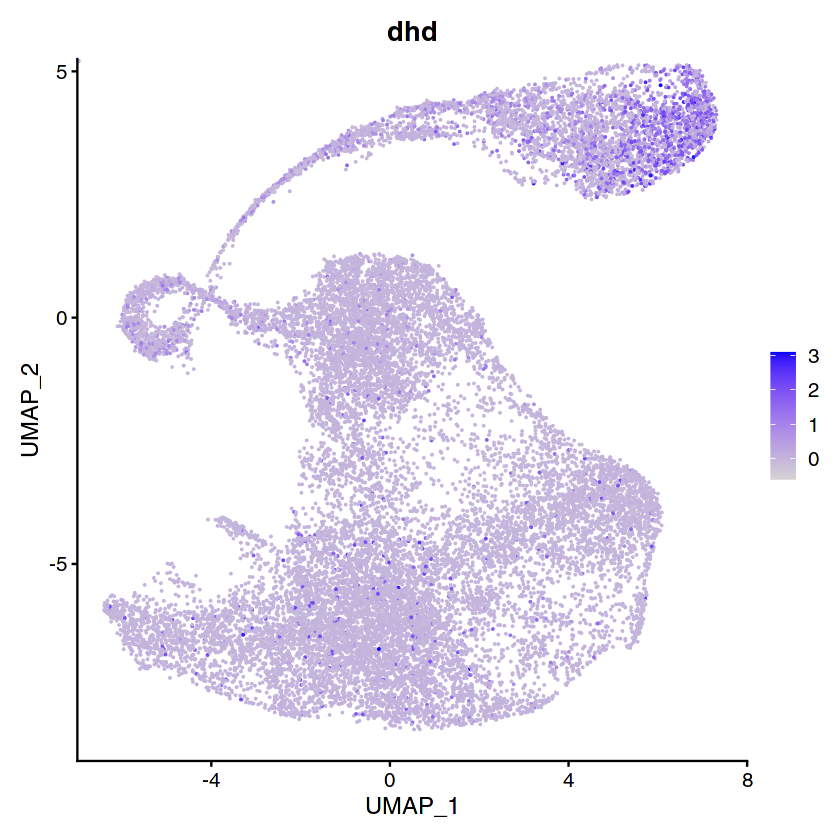

In [4]:
library(ggplot2)
FeaturePlot(tenx, "dhd") + coord_cartesian(c(xmin, xmax), c(ymin, ymax), ex=F)

Differentiation Marker Gene

In [5]:
FindMarkers(
  tenx,
  ident.1 = c("spermatocyte 3", "spermatocyte 4"),
  ident.2 = c("spermatogonium", "mid-late proliferating spermatogonia"),
  only.pos = T
) %>%
  head(20)

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
qvr             6.243932e-228 1.7145412  0.981 0.166 3.121966e-224
CG3491          5.155000e-223 1.6098818  0.998 0.155 2.577500e-219
side-VI         1.262717e-222 1.5907963  1.000 0.658 6.313584e-219
l(2)41Ab        4.031138e-220 1.8513246  1.000 0.426 2.015569e-216
CG5065          2.042273e-217 1.4696010  0.996 0.157 1.021137e-213
CG31601         1.560719e-215 1.4697550  0.996 0.248 7.803596e-212
CG17839         3.103822e-215 1.4719773  0.973 0.085 1.551911e-211
Pzl             1.726892e-213 0.7444958  1.000 0.941 8.634461e-210
bru3            4.001346e-213 1.9521483  0.992 0.135 2.000673e-209
Myo81F          1.020463e-212 0.3364888  1.000 0.999 5.102314e-209
heph            7.831597e-212 0.6017977  1.000 0.966 3.915798e-208
blanks          1.547668e-204 1.2030528  1.000 0.544 7.738340e-201
CG12493         8.002003e-194 1.1379665  1.000 0.482 4.001002e-190
CG15040         6.500324e-193 1.2281568  0.938 0.132 3.250162e-189
NK7.1           8.615511e-193 1.0429743  0.926 0.062 4.307755e-189
CG44774         1.026684e-192 0.4602130  1.000 0.970 5.133419e-189
lovit           1.832880e-191 0.7039469  1.000 0.828 9.164399e-188
Su(Ste):CR42439 5.623876e-190 1.3241959  0.973 0.309 2.811938e-186
kl-3            1.678019e-187 1.5031847  0.981 0.357 8.390097e-184
hpRNA:CR18854   2.453471e-186 1.1602973  0.986 0.353 1.226735e-182

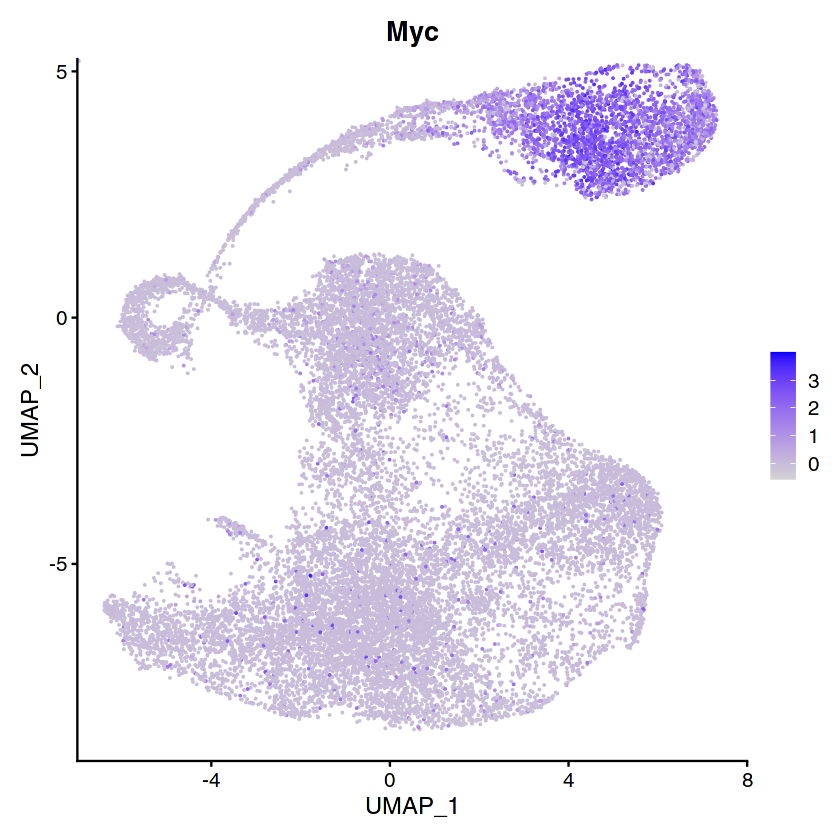

In [6]:
library(ggplot2)
FeaturePlot(tenx, "Myc")  + coord_cartesian(c(xmin, xmax), c(ymin, ymax), ex=F)

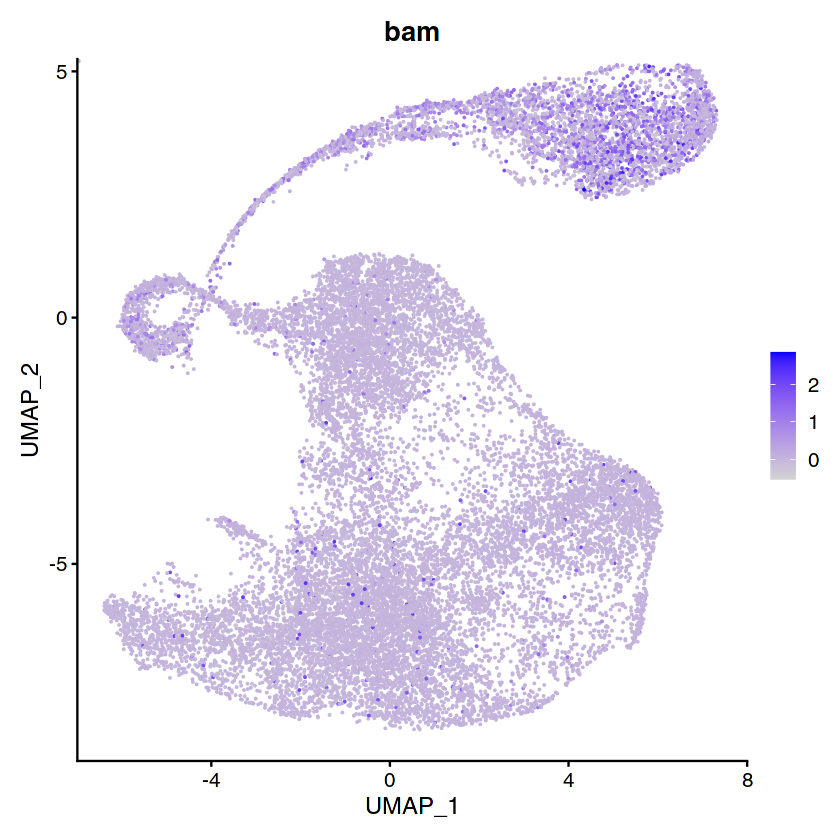

In [7]:
library(ggplot2)
FeaturePlot(tenx, "bam")  + coord_cartesian(c(xmin, xmax), c(ymin, ymax), ex=F)

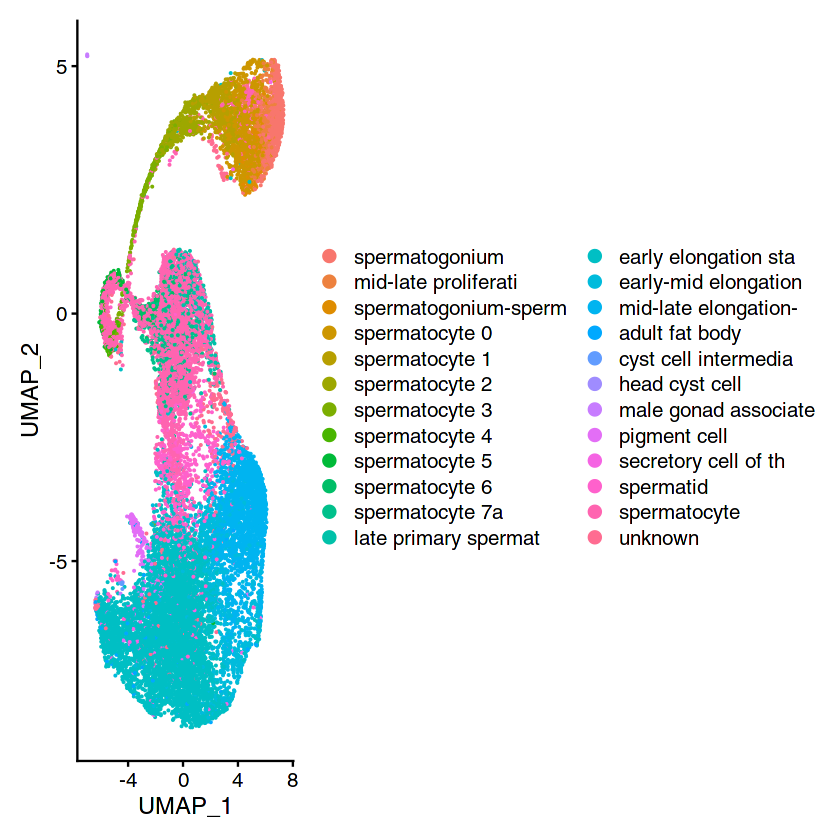

In [8]:
library(stringr)
DimPlot(
  tenx,
  cells = Cells(tenx) %>% subset(
    with(
      FetchData(tenx, c("UMAP_1", "UMAP_2")),
      between(UMAP_1, xmin, xmax) & between(UMAP_2, ymin, ymax)
    )
  )
) +
  scale_color_hue(
    labels = \(v) str_sub(v, 1, 20),
    # guide = guide_legend(ncol=1)
  )

In [9]:
sum(tenx$ident == "spermatogonium")

[1] 709

In [10]:
with_options(
  list(width=180),
  table(tenx$ident[with(FetchData(tenx, c("UMAP_1", "UMAP_2")), between(UMAP_1, xmin, xmax) & between(UMAP_2, ymin, ymax))]) %>%
    sort(dec=T) %>%
    print()
)


             early elongation stage spermatid                                  spermatocyte           mid-late elongation-stage spermatid 
                                         6668                                          3677                                          2228 
                               spermatocyte 0          early-mid elongation-stage spermatid                                spermatogonium 
                                          988                                           943                                           709 
                                    spermatid                               spermatocyte 7a                                spermatocyte 1 
                                          643                                           593                                           582 
                               spermatocyte 2                                       unknown          mid-late proliferating spermatogonia 
                          

Sparse PCA

If we subset to the "spermatogonium" cell type (and include the adjacent "mid-late proliferating spermatogonia"), then we can seek a factor in this subset of cells that explains optimal variance. We can try a PCA on the new object, but that may not mark a specific cell type without a range of other cell types having negative and positive PC values.

On the other hand, there is an optimal SPC1 (sparse principal component) with a fixed number of features to select, where the positive tail cell embedding values exceed the value of the negative tail cell embedding values (it is a skewed distribution). The SPC contains positive features such as "stg" (cell cycle-regulating component that nevertheless may be enriched in GSC). To start, we guessed some guided features to incorporate into the factor (positve GSC: nos, stg, piwi; negative SG/proliferating cell: blanks, Myc, bam). Next, we used power iteration and rounding (missing citation) to arrive at a stable point, which we hope is the optimal SPC1. However, we produced the same SPC1 when our initial vector has uniformly randomly selected 3 positive and 3 negative features.

In [11]:
cells <- Cells(tenx) %>%
  subset(Idents(tenx) == ifelse(seq(ncol(tenx)) %% 2 == 1, "spermatogonium", "mid-late proliferating spermatogonia"))
GSC <- crossprod(
  tenx[["integrated"]]@scale.data[with_seed(0, sample(5000, size = 50)), ],
  c(rep(1, 25), rep(-1, 25)) / sqrt(50)
)[, 1]
GSC <- (GSC - mean(GSC[match(cells, Cells(tenx))])) / sd(GSC[match(cells, Cells(tenx))])
summary(GSC)
c(actual = mean(GSC[match(cells, Cells(tenx))] >= 0.5), expected = pnorm(-0.5))
c(actual = mean(GSC[match(cells, Cells(tenx))] >= 1), expected = pnorm(-1))
tenx$GSC_Score <- GSC

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-5.60023 -0.54195  0.08908  0.06582  0.68142  6.11843 

actual  expected 
0.2835052 0.3085375

actual  expected 
0.1443299 0.1586553

In [12]:
cor(FetchData(tenx, c("GSC_Score", "nos", "stg", "piwi", "ovo", "HP6", "blanks", "Myc", "bam"), cells = cells))

GSC_Score   nos           stg          piwi         ovo        
GSC_Score  1.00000000 -3.751496e-02  0.063467398  0.010035640  0.01621154
nos       -0.03751496  1.000000e+00  0.008976348  0.010035504  0.02979579
stg        0.06346740  8.976348e-03  1.000000000  0.104826185  0.11326700
piwi       0.01003564  1.003550e-02  0.104826185  1.000000000  0.33030637
ovo        0.01621154  2.979579e-02  0.113267000  0.330306373  1.00000000
HP6       -0.05125156  7.271854e-05  0.016938142  0.005990464  0.02231516
blanks    -0.01022703  2.324259e-02 -0.027005239 -0.025336380 -0.01190906
Myc       -0.06528695  1.328281e-02 -0.062533037 -0.161842264 -0.15850343
bam        0.01743269 -7.719648e-02 -0.116742087 -0.087811661 -0.11713024
          HP6           blanks      Myc         bam        
GSC_Score -5.125156e-02 -0.01022703 -0.06528695  0.01743269
nos        7.271854e-05  0.02324259  0.01328281 -0.07719648
stg        1.693814e-02 -0.02700524 -0.06253304 -0.11674209
piwi       5.990464e-03 -0.02533638 -0.16184226 -0.08781166
ovo        2.231516e-02 -0.01190906 -0.15850343 -0.11713024
HP6        1.000000e+00  0.00918809  0.01636873 -0.03551251
blanks     9.188090e-03  1.00000000 -0.02589143  0.01269278
Myc        1.636873e-02 -0.02589143  1.00000000  0.14417924
bam       -3.551251e-02  0.01269278  0.14417924  1.00000000

Warning message:
“Removed 42004 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 42004 rows containing missing values (`geom_point()`).”


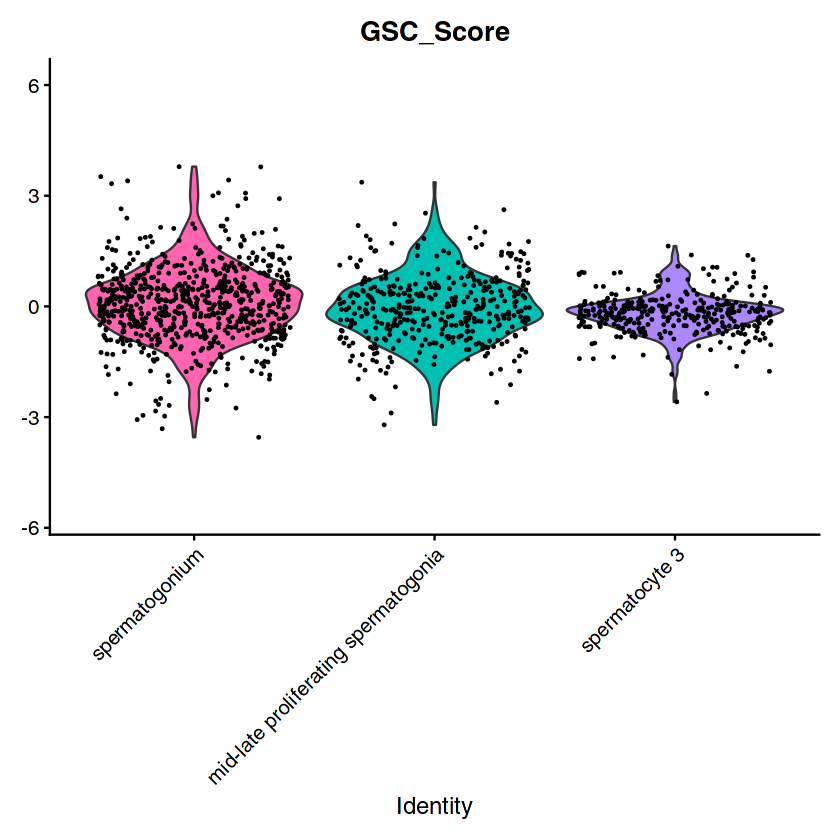

In [13]:
library(ggplot2)
VlnPlot(tenx, "GSC_Score") +
  scale_x_discrete(
    limits = c("spermatogonium", "mid-late proliferating spermatogonia", "spermatocyte 3")
  ) +
  theme(legend.position = "none")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


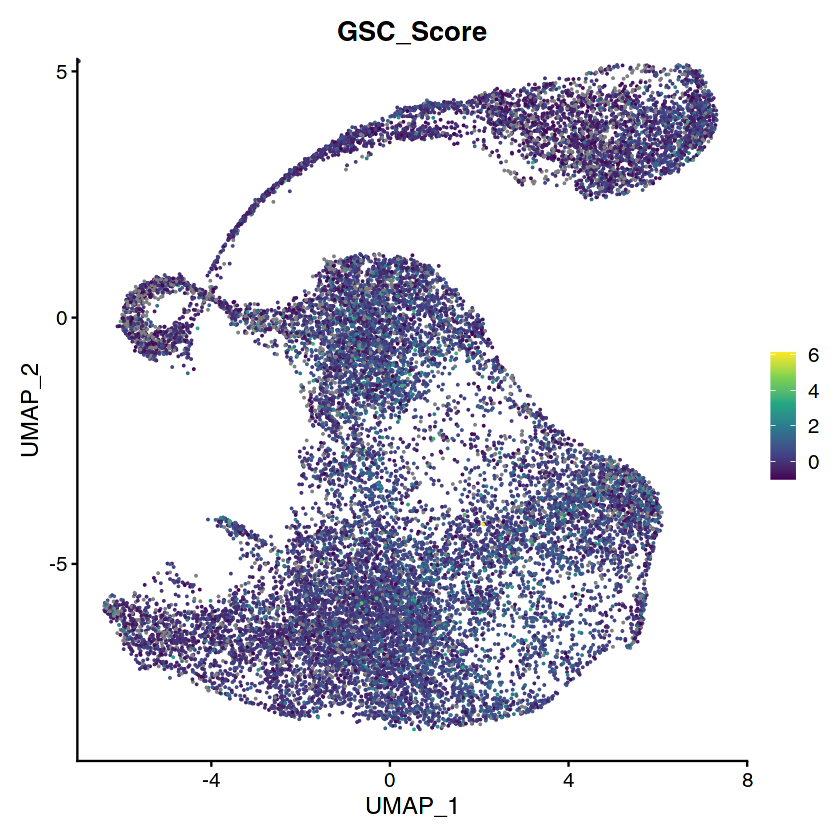

In [14]:
library(ggplot2)
FeaturePlot(tenx, "GSC_Score")  + coord_cartesian(c(xmin, xmax), c(ymin, ymax), ex=F) + scale_color_viridis_c(limits = c(-1, NA))

In [15]:
power_iteration <- function(GSC) {
  scale.data <- tenx[["integrated"]]@scale.data
  cells <- Cells(tenx) %>%
    subset(Idents(tenx) == ifelse(seq(ncol(tenx)) %% 2 == 1, "spermatogonium", "mid-late proliferating spermatogonia"))
  feature.loadings <<- scale.data[, cells] %*% scale(GSC[cells])
  feature.loadings[abs(feature.loadings) < quantile(abs(feature.loadings), 0.95)] <- 0
  feature.loadings <<- feature.loadings / sum(feature.loadings^2)
  summary(feature.loadings)
  GSC <- crossprod(scale.data, feature.loadings)[, 1, drop=T]
  GSC <- (GSC - mean(GSC[match(cells, Cells(tenx))])) / sd(GSC[match(cells, Cells(tenx))])
}
for (i in 1:50) {
  tenx$GSC_Score <- tenx$GSC_Score %>% power_iteration()
}
c(actual = mean(tenx$GSC_Score[cells] >= 0.5), expected = pnorm(-0.5))
c(actual = mean(tenx$GSC_Score[cells] >= 1), expected = pnorm(-1))

actual  expected 
0.3505155 0.3085375

actual  expected 
0.1752577 0.1586553

In [16]:
colData <- readRDS("testis-colData.rds")
colData$GSC_Score <- NA
colData$GSC_Score[match(Cells(tenx), colData$rowname)] <- tenx$GSC_Score
saveRDS(colData, "testis-colData.rds")

Warning message:
“Removed 42004 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 42004 rows containing missing values (`geom_point()`).”


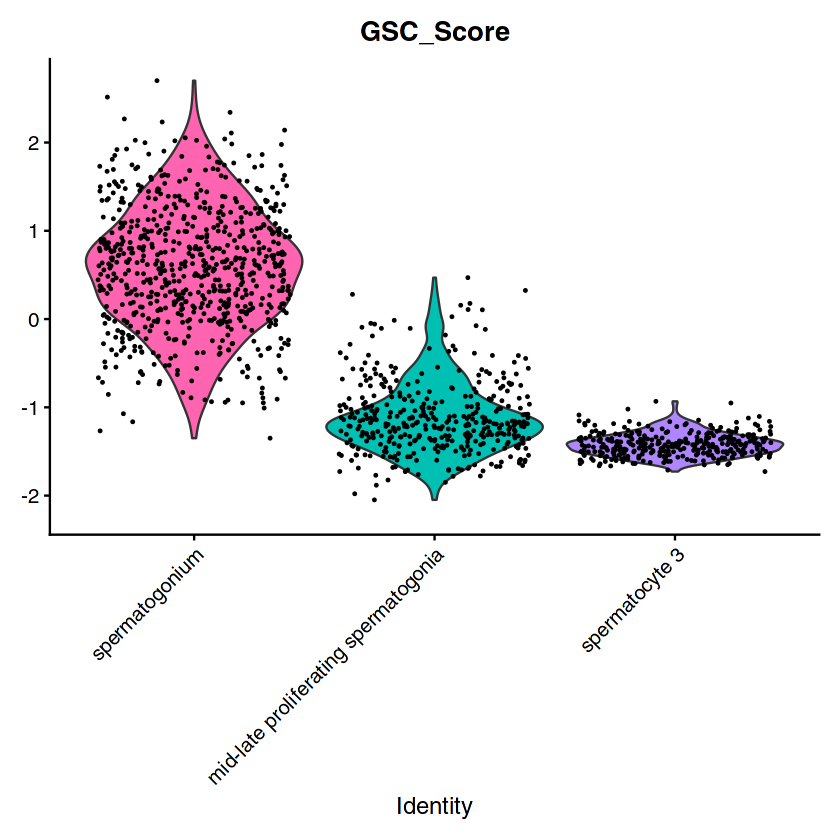

In [17]:
library(ggplot2)
VlnPlot(tenx, "GSC_Score") +
  scale_x_discrete(
    limits = c("spermatogonium", "mid-late proliferating spermatogonia", "spermatocyte 3")
  ) +
  theme(legend.position = "none")

In [18]:
enframe(subset(feature.loadings, feature.loadings != 0)) %>% arrange(desc(abs(value))) %>% head(10)

name           value       
1  asRNA:CR45481  7.316458e-05
2  CG32816        6.391831e-05
3  lncRNA:CR44833 6.140087e-05
4  ovo            4.885599e-05
5  Drep2          4.772581e-05
6  SLO2           3.678095e-05
7  gnu            3.576551e-05
8  stet           3.422692e-05
9  X11Lbeta       3.345823e-05
10 lncRNA:CR45667 3.239921e-05

In [19]:
sort(feature.loadings[, 1], dec=T) %>% head(sum(. > 0)) %>% names()

[1] "asRNA:CR45481"  "CG32816"        "lncRNA:CR44833" "ovo"           
  [5] "Drep2"          "SLO2"           "gnu"            "stet"          
  [9] "X11Lbeta"       "lncRNA:CR45667" "CG32373"        "CG3777"        
 [13] "stg"            "Claspin"        "lncRNA:CR44357" "FASN3"         
 [17] "piwi"           "lncRNA:CR45665" "TM4SF"          "kirre"         
 [21] "c(3)G"          "CG15047"        "CG32365"        "stai"          
 [25] "CG7720"         "CG33494"        "CG3635"         "rho"           
 [29] "CG12851"        "nvd"            "lncRNA:CR42646" "Tbh"           
 [33] "l(2)03659"      "esg"            "CG14545"        "asRNA:CR45715" 
 [37] "lncRNA:CR44440" "goe"            "grh"            "mGluR"         
 [41] "CG34031"        "Pdfr"           "Ir67c"          "nenya"         
 [45] "CG31789"        "SKIP"           "chn"            "CG42541"       
 [49] "CG9650"         "CG15312"        "Rim"            "fuss"          
 [53] "inaE"           "Ptp61F"         "2mit"           "ey"            
 [57] "ftz-f1"         "CG30403"        "Reph"           "CG14696"       
 [61] "ru"             "Lime"           "egr"            "LanB1"         
 [65] "CG32625"        "nAChRalpha3"    "Ank2"           "CG34355"       
 [69] "eag"            "CG43689"        "CG32483"        "CG16978"       
 [73] "CG14298"        "RapGAP1"        "unpg"           "yellow-f2"     
 [77] "CG11085"        "crm"            "CG34353"        "CG17224"       
 [81] "Asph"           "side-V"         "CG12239"        "CG5953"        
 [85] "RecQ4"          "zfh1"           "fend"           "alpha-Man-IIb" 
 [89] "asRNA:CR46029"  "BthD"           "nAChRalpha4"    "CG30484"       
 [93] "CG2493"         "CG30424"        "snRNA:U5:38ABa" "Snap25"        
 [97] "Parp"           "pico"           "CG4306"         "CaMKI"         
[101] "shot"           "asRNA:CR44375"  "Lsp1gamma"      "lncRNA:CR31044"
[105] "CG3726"         "Ts"             "apt"            "lncRNA:CR45937"
[109] "CG30379"        "l(2)01289"      "wisp"           "CG32368"       
[113] "CG43759"        "CG7227"         "CG32793"        "zfh2"          
[117] "Scp1"           "chrb"           "Pld"            "qua"           
[121] "Hk"             "Prosap"         "CG34357"        "CG7724"        
[125] "dhd"            "CG2556"         "Octalpha2R"     "ed"            
[129] "lncRNA:CR46003" "Fas1"           "CG42340"        "Pu"            
[133] "CG4678"         "CG3631"         "CG2694"         "uif"           
[137] "lncRNA:CR32773" "hid"            "thoc7"          "Rs1"           
[141] "Ac3"            "tow"            "CG15484"        "CG40006"       
[145] "pgc"            "wake"           "Ten-a"          "scro"          
[149] "solo"           "lncRNA:CR45400" "kay"            "Debcl"         
[153] "aos"            "qsm"            "Pde9"           "dpr21"         
[157] "CG12811"        "CG3655"         "unc-13"         "NaCP60E"       
[161] "beat-VI"        "CycE"           "Aduk"           "CG6770"        
[165] "Spn"            "N"              "lncRNA:CR45224" "CG13784"       
[169] "Cad87A"         "CG33521"        "CG4849"         "Nrg"

In [20]:
mypc <- svd(t(scale(t(tenx[["integrated"]]@scale.data)[cells, ], scale=F)))
PC_1 <- mypc$d[1] * mypc$v[, 1]
PC_2 <- mypc$d[2] * mypc$v[, 2]
PC_3 <- mypc$d[3] * mypc$v[, 3]

In [21]:
cor(tibble(FetchData(tenx, c("GSC_Score", "nos", "piwi", "Myc", "lncRNA:Hsromega"), cells = cells), PC_1, PC_2, PC_3))

GSC_Score    nos          piwi        Myc        
GSC_Score        1.000000000  0.008490026  0.49368968 -0.25354920
nos              0.008490026  1.000000000  0.01003550  0.01328281
piwi             0.493689679  0.010035504  1.00000000 -0.16184226
Myc             -0.253549201  0.013282808 -0.16184226  1.00000000
lncRNA:Hsromega -0.284836285  0.038393198 -0.18592812  0.12941171
PC_1             0.994560144  0.022433748  0.48161608 -0.24555518
PC_2             0.009094002 -0.021103616  0.03347973  0.16580993
PC_3             0.025212686  0.142198873  0.19480466 -0.09421855
                lncRNA:Hsromega PC_1          PC_2          PC_3         
GSC_Score       -0.28483628      9.945601e-01  9.094002e-03  2.521269e-02
nos              0.03839320      2.243375e-02 -2.110362e-02  1.421989e-01
piwi            -0.18592812      4.816161e-01  3.347973e-02  1.948047e-01
Myc              0.12941171     -2.455552e-01  1.658099e-01 -9.421855e-02
lncRNA:Hsromega  1.00000000     -2.690234e-01 -9.216447e-02 -4.313416e-02
PC_1            -0.26902342      1.000000e+00  1.381349e-16 -2.352278e-16
PC_2            -0.09216447      1.381349e-16  1.000000e+00  3.066805e-16
PC_3            -0.04313416     -2.352278e-16  3.066805e-16  1.000000e+00

Warning message:
“Removed 42004 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 42004 rows containing missing values (`geom_point()`).”


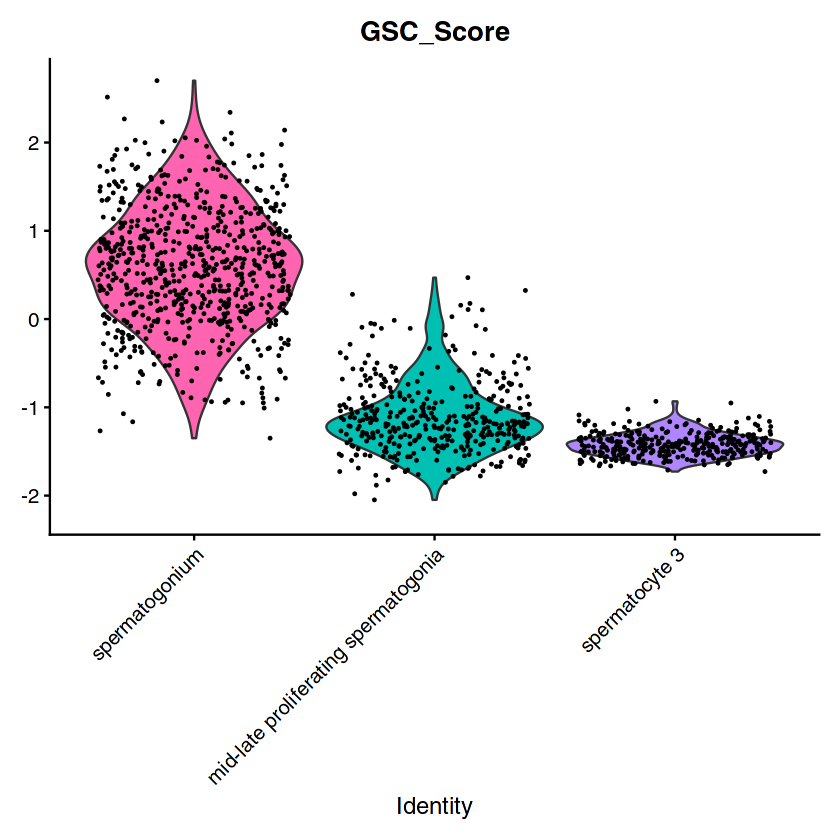

In [22]:
VlnPlot(tenx, "GSC_Score") +
  scale_x_discrete(
    limits = c("spermatogonium", "mid-late proliferating spermatogonia", "spermatocyte 3")
  ) +
  # coord_cartesian(NULL, c(0, 3)) +
  theme(legend.position = "none")

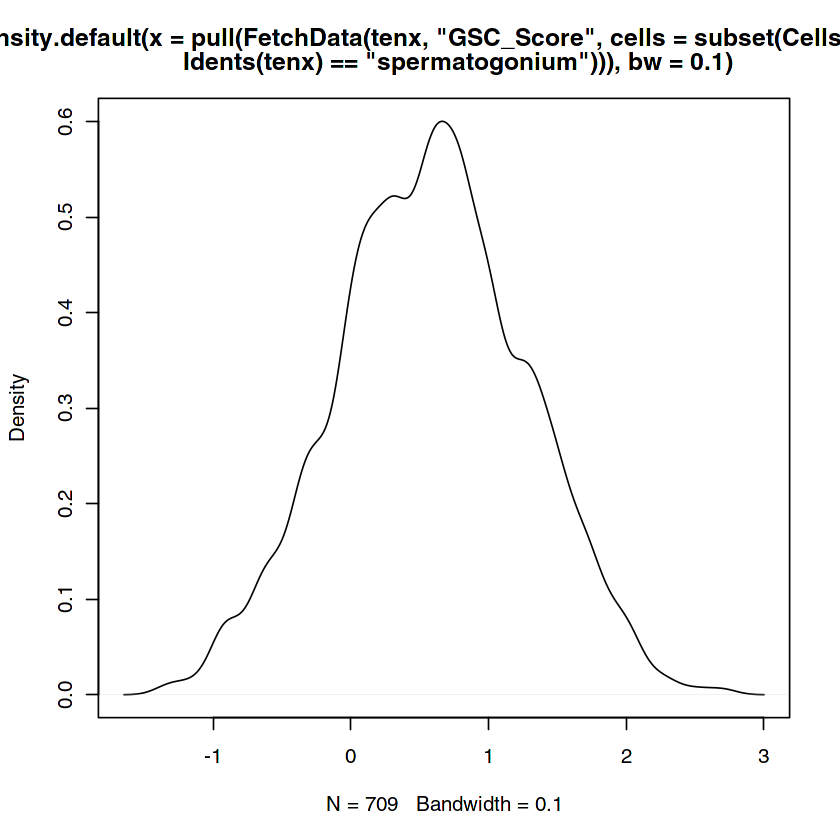

In [23]:
plot(density(pull(FetchData(tenx, "GSC_Score", cells=subset(Cells(tenx), Idents(tenx) == "spermatogonium"))), bw=0.1))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


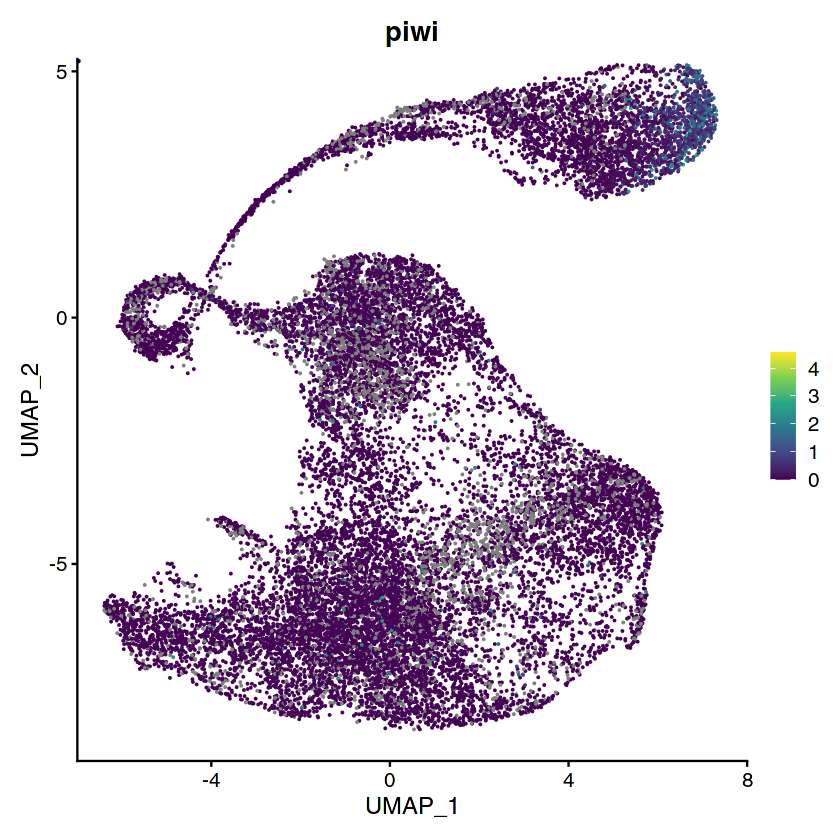

In [24]:
library(ggplot2)
FeaturePlot(tenx, "piwi")  + coord_cartesian(c(xmin, xmax), c(ymin, ymax), ex=F) + scale_color_viridis_c(limits = c(0, NA))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


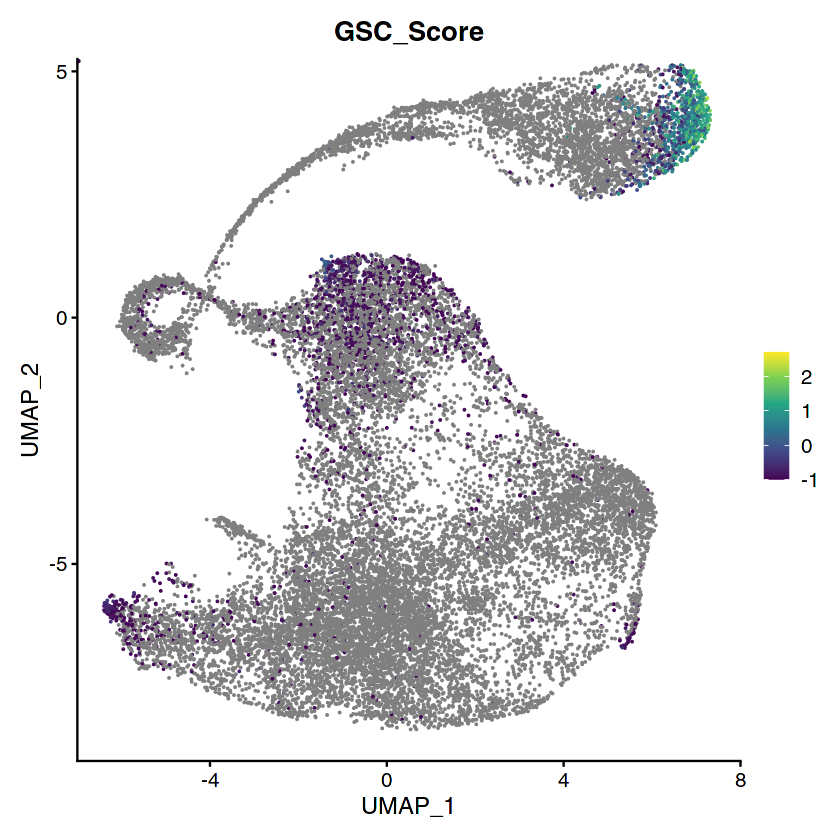

In [25]:
library(ggplot2)
FeaturePlot(tenx, "GSC_Score")  + coord_cartesian(c(xmin, xmax), c(ymin, ymax), ex=F) + scale_color_viridis_c(limits = c(-1, NA))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


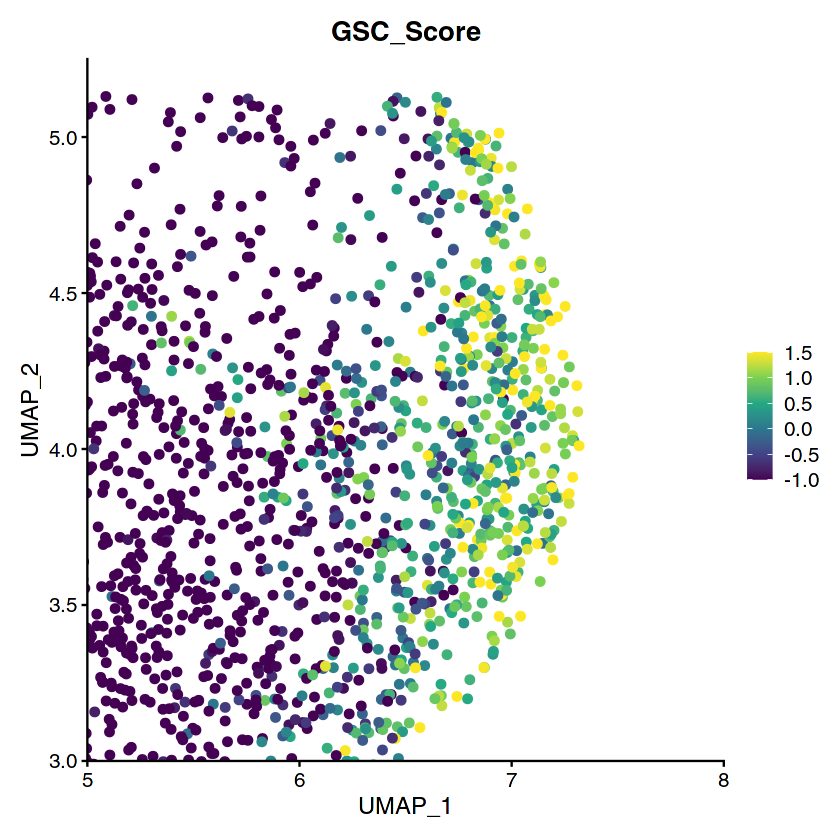

In [26]:
library(ggplot2)
FeaturePlot(tenx, "GSC_Score", pt.size=2)  + coord_cartesian(c(5, 8), c(3, 5.25), ex=F) + scale_color_viridis_c(limits = c(-1, 1.5), oob=scales::squish)

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


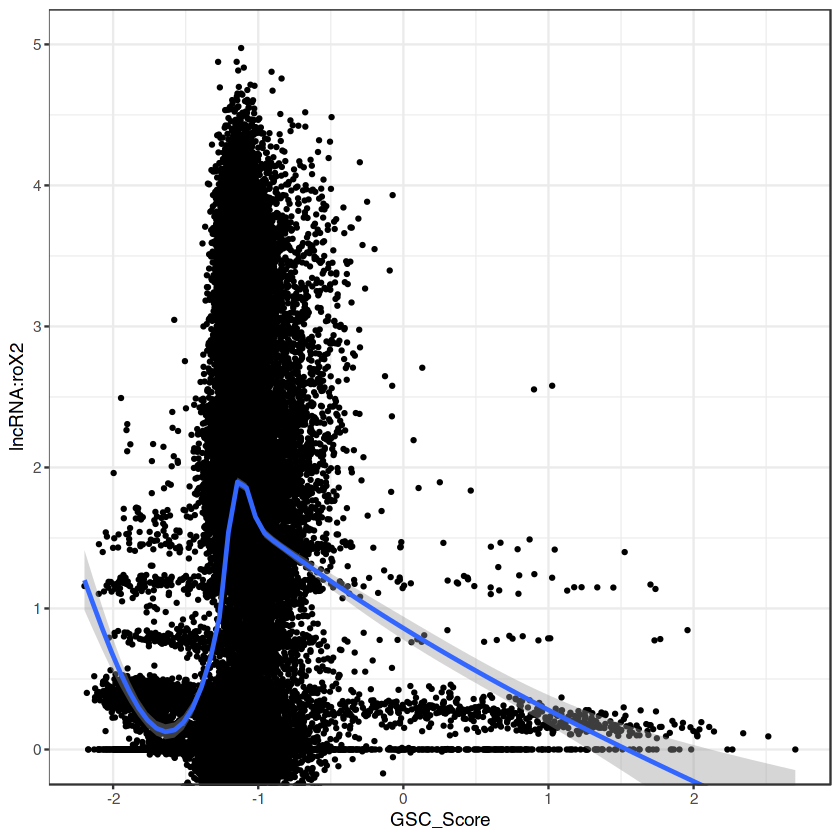

In [27]:
ggplot(
  FetchData(tenx, c("GSC_Score", "lncRNA:roX2")),
  aes(GSC_Score, `lncRNA:roX2`)
) +
  geom_point(stroke=NA) +
  geom_smooth() +
  coord_cartesian(NULL, c(0, 5)) +
  theme_bw()

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


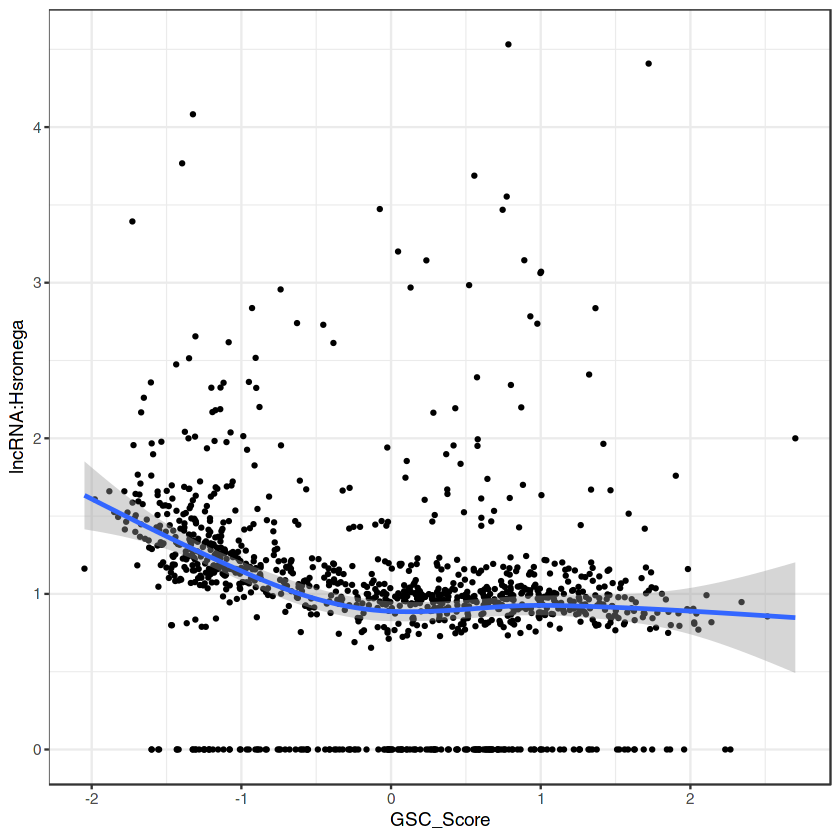

In [28]:
ggplot(
  FetchData(tenx, c("GSC_Score", "lncRNA:Hsromega")) %>%
    subset(Idents(tenx) %in% c("spermatogonium", "mid-late proliferating spermatogonia")),
  aes(GSC_Score, `lncRNA:Hsromega`)
) +
  geom_point(stroke=NA) +
  geom_smooth() +
  theme_bw()

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


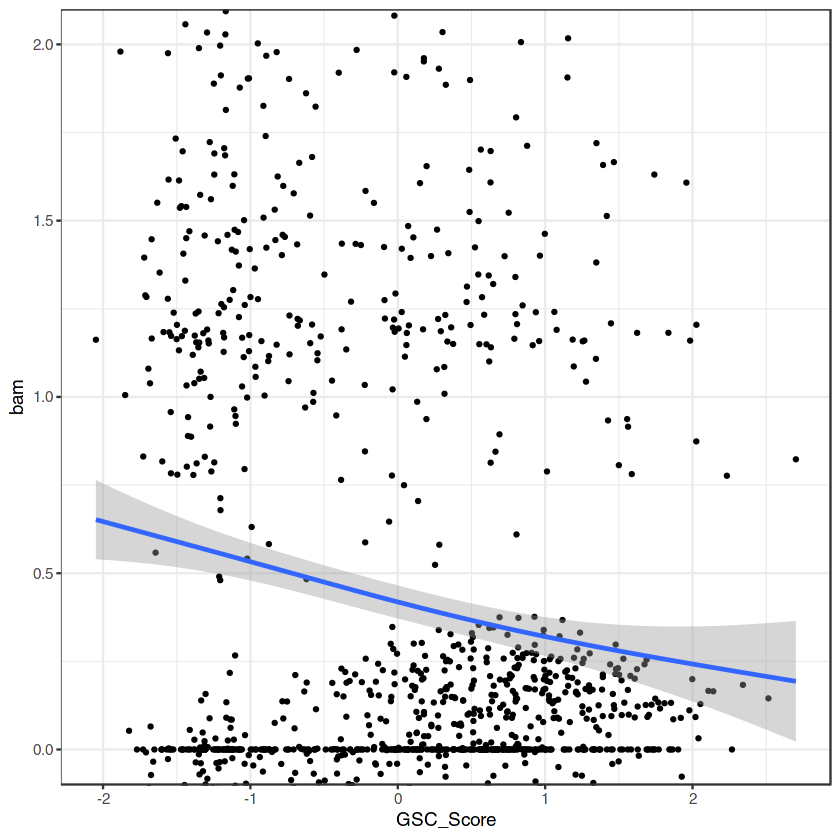

In [29]:
ggplot(
  FetchData(tenx, c("GSC_Score", "bam")) %>%
    subset(Idents(tenx) %in% c("spermatogonium", "mid-late proliferating spermatogonia")),
  aes(GSC_Score, bam)
) +
  geom_point(stroke=NA) +
  geom_smooth() +
  coord_cartesian(NULL, c(0, 2)) +
  theme_bw()

Warning message:
“Could not find Mst87F in the default search locations, found in RNA assay instead”
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


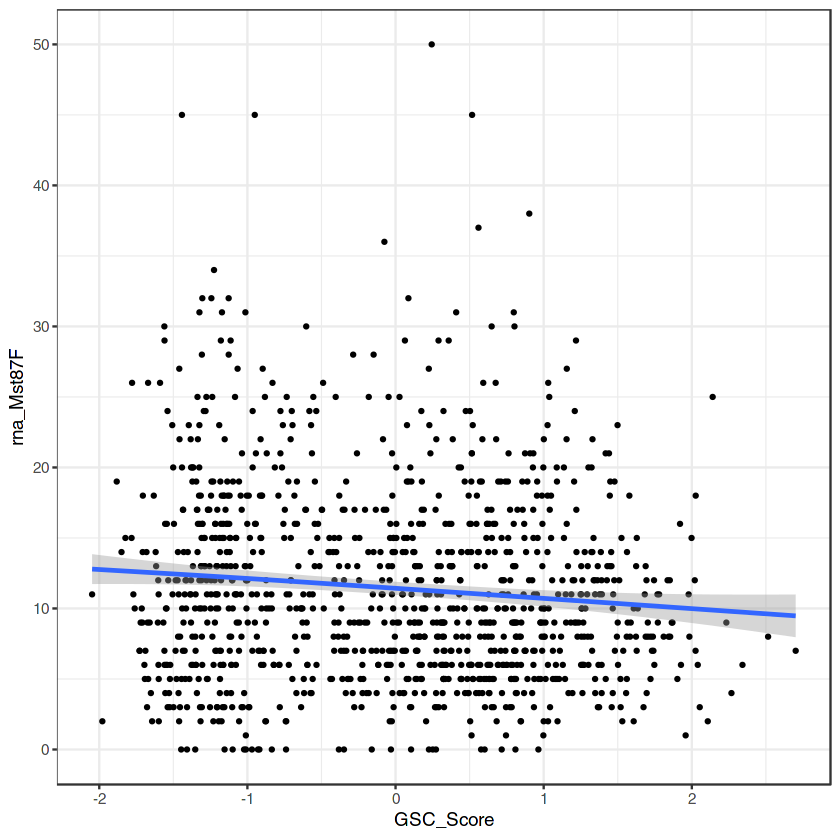

In [30]:
ggplot(
  FetchData(tenx, c("GSC_Score", "Mst87F")) %>%
    subset(Idents(tenx) %in% c("spermatogonium", "mid-late proliferating spermatogonia")),
  aes(GSC_Score, rna_Mst87F)
) +
  geom_point(stroke=NA) +
  geom_smooth() +
  theme_bw()

chr X Dosage Covariate

In [31]:
Xdata <- as.matrix(
  tenx[["RNA"]]@counts[tenx[["RNA"]]@meta.features$chr == "X", ]
)
dim(Xdata)

[1]  2686 43454

In [32]:
library(glmGamPoi)
Xloadings <- glm_gp(
  Xdata,
  size_factors = tenx$size_factor,
  verbose = TRUE
)
summary(as.numeric(Xloadings$Beta))


Attaching package: ‘glmGamPoi’


The following object is masked from ‘package:ggplot2’:

    vars


The following object is masked from ‘package:dplyr’:

    vars


Make initial dispersion estimate

Make initial beta estimate

Estimate beta

Estimate dispersion

Fit dispersion trend

Shrink dispersion estimates

Estimate beta again



      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-100000000         -5         -3  -12174239         -1          4 

In [46]:
gc()
xfeRes <- sapply(
  seq(ncol(tenx)),
  \(i) optimize(
    \(x) sum(
      -dnbinom(
        Xdata[, i],
        size = Xloadings$overdispersions,
        mu = exp(as.numeric(Xloadings$Beta)) * tenx$size_factor[i] * x,
        log = TRUE
      )
    ),
    c(0, 1e6)
  ),
  simplify=FALSE
)

used       (Mb)   gc trigger (Mb)    max used   (Mb)   
Ncells    7400969  395.3   14466185   772.6   14466185   772.6
Vcells 1027404045 7838.5 1587891360 12114.7 1408283384 10744.4

Warning message in optimize(function(x) sum(-dnbinom(Xdata[, i], size = Xloadings$overdispersions, :
“NA/Inf replaced by maximum positive value”
Warning message in optimize(function(x) sum(-dnbinom(Xdata[, i], size = Xloadings$overdispersions, :
“NA/Inf replaced by maximum positive value”
Warning message in optimize(function(x) sum(-dnbinom(Xdata[, i], size = Xloadings$overdispersions, :
“NA/Inf replaced by maximum positive value”
Warning message in optimize(function(x) sum(-dnbinom(Xdata[, i], size = Xloadings$overdispersions, :
“NA/Inf replaced by maximum positive value”
Warning message in optimize(function(x) sum(-dnbinom(Xdata[, i], size = Xloadings$overdispersions, :
“NA/Inf replaced by maximum positive value”
Warning message in optimize(function(x) sum(-dnbinom(Xdata[, i], size = Xloadings$overdispersions, :
“NA/Inf replaced by maximum positive value”
Warning message in optimize(function(x) sum(-dnbinom(Xdata[, i], size = Xloadings$overdispersions, :
“NA/Inf replaced by maximum p

In [48]:
length(sapply(xfeRes, \(lst) lst$minimum))

[1] 43454

In [49]:
dim(tenx)

[1]  5000 43454

In [50]:
tibble(ident=Idents(tenx), FE=sapply(xfeRes, \(obj) obj$minimum)) %>% group_by(ident) %>% summarise_all(\(v) quantile(v, 0.25
)) %>% arrange(FE)

ident                                         FE       
1  late primary spermatocyte                     0.3047907
2  spermatocyte                                  0.3260034
3  secretory cell of the male reproductive tract 0.3884711
4  early elongation stage spermatid              0.3933189
5  adult fat body                                0.4038232
6  spermatid                                     0.4098691
7  spermatocyte 3                                0.4244252
8  spermatocyte 2                                0.4252341
9  spermatocyte 4                                0.4297359
10 early-mid elongation-stage spermatid          0.4326076
11 spermatocyte 1                                0.4456018
12 unknown                                       0.4604583
13 spermatocyte 6                                0.4752079
14 spermatogonium                                0.4774060
15 mid-late proliferating spermatogonia          0.4781353
16 spermatogonium-spermatocyte transition        0.4782670
17 spermatocyte 5                                0.4784003
18 mid-late elongation-stage spermatid           0.4915259
19 spermatocyte 0                                0.4996572
20 pigment cell                                  0.5065927
21 spermatocyte 7a                               0.6124656
22 muscle cell                                   0.7314024
23 hemocyte                                      0.8245002
24 male gonad associated epithelium              0.8780199
25 adult tracheal cell                           1.0772030
26 cyst cell intermediate                        1.1137838
27 cyst cell branch a                            1.5082037
28 late cyst cell branch a                       1.8202521
29 late cyst cell branch b                       1.8315165
30 cyst cell branch b                            1.9128469
31 head cyst cell                                2.0131145
32 early cyst cell 2                             2.0615662
33 spermatocyte cyst cell branch b               2.0916631
34 spermatocyte cyst cell branch a               2.1310967
35 early cyst cell 1                             2.8634714
36 cyst stem cell                                8.2364724

In [53]:
colData <- tibble(
  colData,
  logXFE = rep(NA, length(rowname)) %>%
    replace(
      match(Cells(tenx), rowname),
      log(
        sapply(xfeRes, \(obj) obj$minimum)
      )
    ),
)
saveRDS(colData, "testis-colData.rds")

Splitting Cluster of Interest

The SPC1 could be used as a variable to regress, or we could use it as a utility to cut the "spermatogonium" cluster. We chose the latter, because "Mst87F" starts to decline at `scale(SPC1) >= 1`. Thus, the factor of interest has a new level which has a subset of the "spermatogonium" cells.

[1] 190

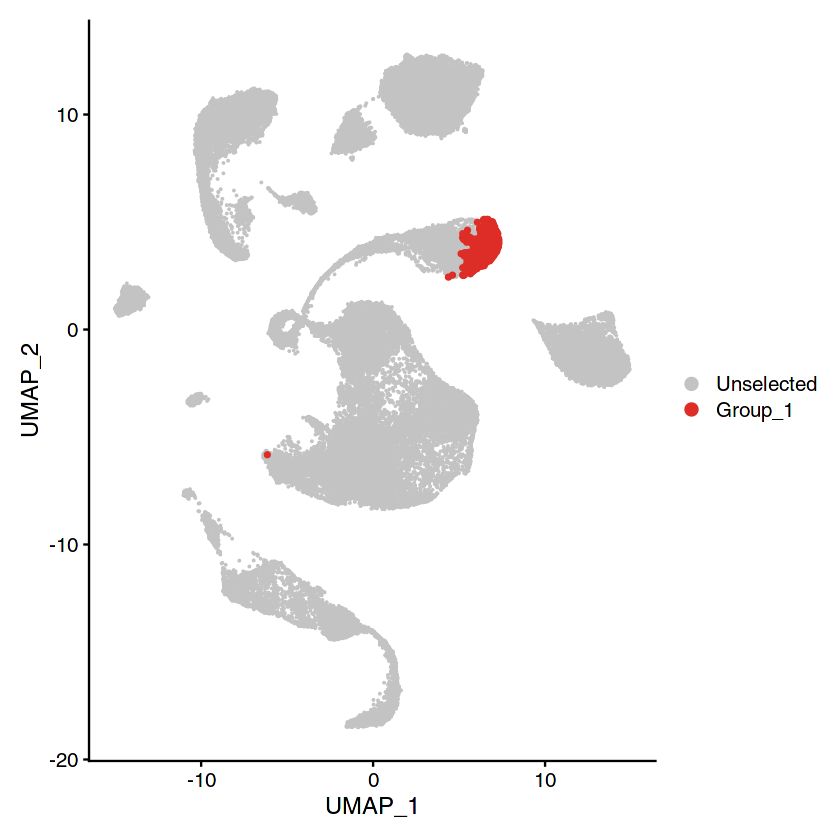

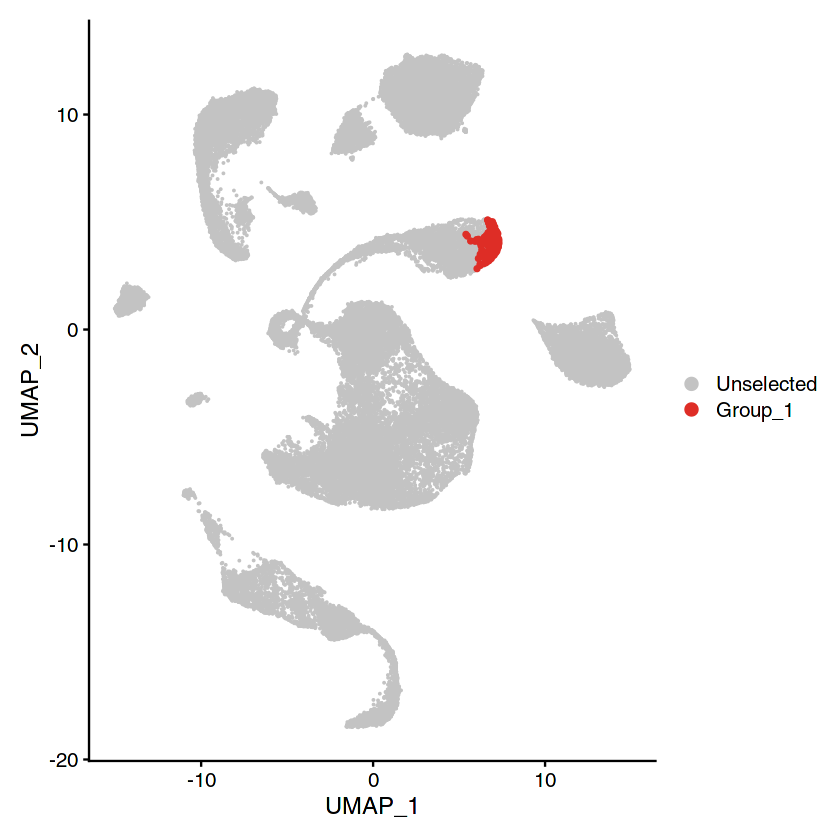

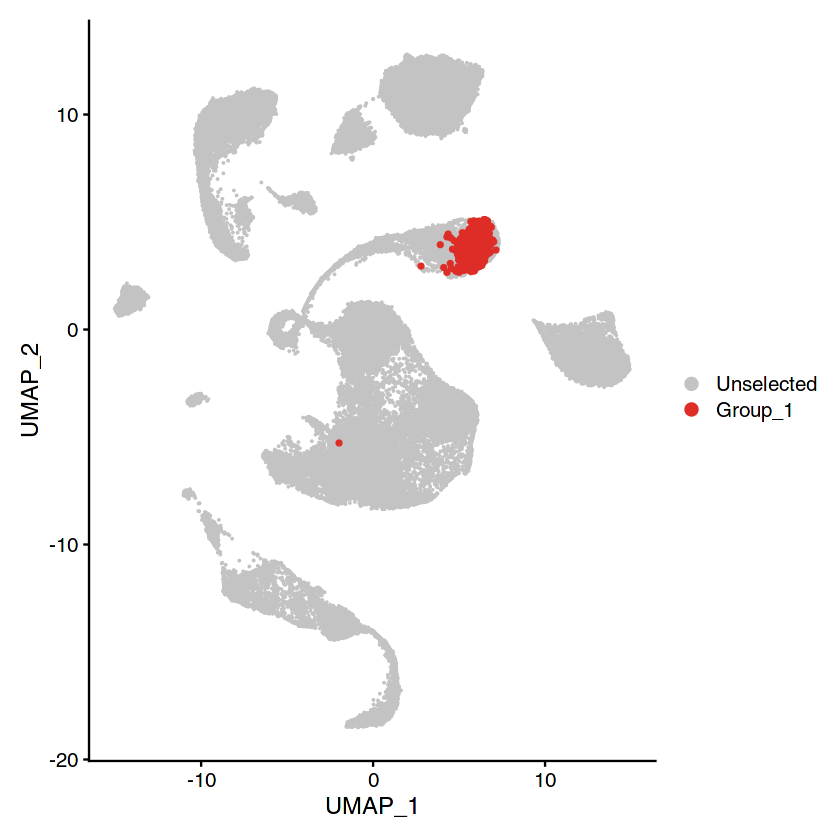

In [54]:
sum(Idents(tenx) == "spermatogonium" & tenx$GSC_Score >= 1)
DimPlot(tenx ,cells.highlight = Cells(tenx) %>% subset(Idents(tenx) == "spermatogonium"))
DimPlot(tenx ,cells.highlight = Cells(tenx) %>% subset(Idents(tenx) == "spermatogonium" & tenx$GSC_Score >= 1))
DimPlot(tenx ,cells.highlight = Cells(tenx) %>% subset(Idents(tenx) == "mid-late proliferating spermatogonia"))

In [55]:
enframe(table(Idents(tenx)))

name                                          value
1  spermatogonium                                  709
2  mid-late proliferating spermatogonia            401
3  spermatogonium-spermatocyte transition          202
4  spermatocyte 0                                  988
5  spermatocyte 1                                  582
6  spermatocyte 2                                  541
7  spermatocyte 3                                  340
8  spermatocyte 4                                  146
9  spermatocyte 5                                  181
10 spermatocyte 6                                  202
11 spermatocyte 7a                                 593
12 late primary spermatocyte                       301
13 early elongation stage spermatid               6681
14 early-mid elongation-stage spermatid            945
15 mid-late elongation-stage spermatid            2228
16 cyst stem cell                                  344
17 early cyst cell 1                               657
18 early cyst cell 2                               353
19 spermatocyte cyst cell branch a                 491
20 spermatocyte cyst cell branch b                 215
21 cyst cell branch a                              299
22 cyst cell branch b                              311
23 late cyst cell branch a                         156
24 late cyst cell branch b                         316
25 adult fat body                                  109
26 muscle cell                                    3513
27 adult tracheal cell                             619
28 cyst cell intermediate                         1797
29 head cyst cell                                 1365
30 hemocyte                                        800
31 male gonad associated epithelium              11063
32 pigment cell                                    475
33 secretory cell of the male reproductive tract   117
34 spermatid                                       643
35 spermatocyte                                   3677
36 unknown                                        1094

In [57]:
library(dplyr)
library(SingleCellExperiment)
Y <- readRDS("testis-counts.rds")
colData <- readRDS("testis-colData.rds")

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, 

In [58]:
colData <- colData %>%
  mutate(
    ident = ident %>%
      factor(c("germline stem cell", levels(.))) %>%
      replace(
        GSC_Score >= 1,
        "germline stem cell"
      )
  )

In [59]:
levels(colData$ident)

[1] "germline stem cell"                           
 [2] "spermatogonium"                               
 [3] "mid-late proliferating spermatogonia"         
 [4] "spermatogonium-spermatocyte transition"       
 [5] "spermatocyte 0"                               
 [6] "spermatocyte 1"                               
 [7] "spermatocyte 2"                               
 [8] "spermatocyte 3"                               
 [9] "spermatocyte 4"                               
[10] "spermatocyte 5"                               
[11] "spermatocyte 6"                               
[12] "spermatocyte 7a"                              
[13] "late primary spermatocyte"                    
[14] "early elongation stage spermatid"             
[15] "early-mid elongation-stage spermatid"         
[16] "mid-late elongation-stage spermatid"          
[17] "cyst stem cell"                               
[18] "early cyst cell 1"                            
[19] "early cyst cell 2"                            
[20] "spermatocyte cyst cell branch a"              
[21] "spermatocyte cyst cell branch b"              
[22] "cyst cell branch a"                           
[23] "cyst cell branch b"                           
[24] "late cyst cell branch a"                      
[25] "late cyst cell branch b"                      
[26] "adult fat body"                               
[27] "muscle cell"                                  
[28] "adult tracheal cell"                          
[29] "cyst cell intermediate"                       
[30] "head cyst cell"                               
[31] "hemocyte"                                     
[32] "male gonad associated epithelium"             
[33] "pigment cell"                                 
[34] "secretory cell of the male reproductive tract"
[35] "spermatid"                                    
[36] "spermatocyte"                                 
[37] "unknown"

In [60]:
write(deparse(levels(colData$ident)[c(1:16, 26, 35:36)]), stdout())

c("germline stem cell", "spermatogonium", "mid-late proliferating spermatogonia", 
"spermatogonium-spermatocyte transition", "spermatocyte 0", "spermatocyte 1", 
"spermatocyte 2", "spermatocyte 3", "spermatocyte 4", "spermatocyte 5", 
"spermatocyte 6", "spermatocyte 7a", "late primary spermatocyte", 
"early elongation stage spermatid", "early-mid elongation-stage spermatid", 
"mid-late elongation-stage spermatid", "adult fat body", "spermatid", 
"spermatocyte")


In [61]:
subset(
  colData,
  ident %in% levels(ident)[c(17:25, 29:30)] &
    batch %in% c("sample1", "sample2", "sample3")
)$ident %>%
  droplevels() %>%
  table()

.
                 cyst stem cell               early cyst cell 1 
                            344                             657 
              early cyst cell 2 spermatocyte cyst cell branch a 
                            353                             491 
spermatocyte cyst cell branch b              cyst cell branch a 
                            215                             299 
             cyst cell branch b         late cyst cell branch a 
                            311                             156 
        late cyst cell branch b          cyst cell intermediate 
                            316                            1797 
                 head cyst cell 
                           1365 

In [6]:
write(deparse(levels(colData$ident)[c(17:25, 29:30)]), stdout())

c("cyst stem cell", "early cyst cell 1", "early cyst cell 2", 
"spermatocyte cyst cell branch a", "spermatocyte cyst cell branch b", 
"cyst cell branch a", "cyst cell branch b", "late cyst cell branch a", 
"late cyst cell branch b", "cyst cell intermediate", "head cyst cell"
)


In [62]:
celltypes <- c(
  "spermatogonium", "germline stem cell", "mid-late proliferating spermatogonia",
  "spermatogonium-spermatocyte transition", 
  "spermatocyte 0", "spermatocyte 1", "spermatocyte 2", "spermatocyte 3", 
  "spermatocyte 4", "spermatocyte 5", "spermatocyte 6", "spermatocyte 7a", 
  "late primary spermatocyte", "early elongation stage spermatid", 
  "early-mid elongation-stage spermatid", "mid-late elongation-stage spermatid", 
  "adult fat body", "spermatid", "spermatocyte"
)
sce <- SingleCellExperiment(
  Y,
  colData = colData %>%
    mutate(
      ident = ident %>% factor(celltypes),
      batch = batch %>%
        factor(c("sample1", "sample2", "sample3")) %>%
        `contrasts<-`(value = contr.sum(3)),
      logFeature = log(nFeature_RNA) / log(10),
      normNFeature = scale(logFeature)[, 1],
    )
)
dim(sce)
sce <- sce[
  ,
  subset(colData, batch %in% c("sample1", "sample2", "sample3") & ident %in% celltypes)$rowname
]
# CG30116: It is low-percentage, and has a particular numerical issue in glmGamPoi
# fitting the overdispersion nuisance parameter where the Hessian is not positive
# definite.
sce <- sce[
  which(tabulate(1 + assay(sce)@i, nrow(sce)) >= 50) %>%
    setdiff(match(c("CG30116", "Eip75B", "CG10960", "Pdp1"), rownames(Y))),
]
dim(sce)
saveRDS(sce, "testis-counts-germline.rds")

[1] 17825 43828

[1] 11883 19471

In [63]:
library(glmGamPoi)
glm_gp(
  sce[c("vas", "nos", "lncRNA:roX2", "N", "Dl", "ovo", "stg", "bam", "lncRNA:Hsromega"), ],
  ~ ident + batch + pctMito + pctRibo + normNFeature,
  size_factors = sce$size_factor,
  on_disk = FALSE,
  overdispersion_shrinkage = FALSE
)$Beta


Attaching package: ‘glmGamPoi’


The following object is masked from ‘package:ggplot2’:

    vars


The following object is masked from ‘package:dplyr’:

    vars




Intercept  identgermline stem cell
vas             -0.8016616  0.03616364            
nos             -0.6173062  0.06032360            
lncRNA:roX2     -1.4259789 -0.03843009            
N                0.6948292  0.02977200            
Dl              -0.5498436 -0.05792118            
ovo              0.3526903  0.40699698            
stg             -0.6758013  0.80287512            
bam             -2.4407404 -0.71238296            
lncRNA:Hsromega  2.2406048 -0.50325278            
                identmid-late proliferating spermatogonia
vas             -0.2114347                               
nos             -0.3305209                               
lncRNA:roX2      0.2036404                               
N               -0.1252955                               
Dl               0.4714225                               
ovo             -1.6831401                               
stg             -0.4008165                               
bam              0.7058306                               
lncRNA:Hsromega -0.3456995                               
                identspermatogonium-spermatocyte transition identspermatocyte 0
vas             -0.52493416                                 -0.09097494        
nos             -0.27595819                                 -0.52840923        
lncRNA:roX2      0.52604849                                  0.56615637        
N               -1.11315261                                 -2.42028899        
Dl               0.18818877                                  0.91817200        
ovo             -2.77216029                                 -6.44429823        
stg             -1.27468928                                 -2.14467593        
bam              0.53893437                                  0.45214452        
lncRNA:Hsromega -0.08620603                                  0.12968320        
                identspermatocyte 1 identspermatocyte 2 identspermatocyte 3
vas              0.04260090         -0.2436357          -0.6939124         
nos             -0.40130556         -0.8685285          -2.6297896         
lncRNA:roX2     -0.09407102         -0.6393003          -1.0283288         
N               -4.13817305         -4.3637067          -5.4837506         
Dl               0.14859674         -1.0013614          -1.7340773         
ovo             -7.03205327         -5.2360311          -6.3392336         
stg             -4.18989182         -5.3336585          -5.0735149         
bam             -0.10977397         -0.3177949          -0.5244652         
lncRNA:Hsromega  0.08683967          0.2229452           0.4374639         
                identspermatocyte 4 identspermatocyte 5 ⋯
vas              -1.6524280          -3.175103          ⋯
nos              -3.0609626          -4.847274          ⋯
lncRNA:roX2      -2.9274390          -1.580113          ⋯
N               -23.7123552          -5.171951          ⋯
Dl               -2.0591901          -2.257215          ⋯
ovo             -25.1866514          -5.345755          ⋯
stg             -25.9314102         -25.924507          ⋯
bam              -0.9462622          -1.701673          ⋯
lncRNA:Hsromega -55.8514741          -1.384312          ⋯
                identearly-mid elongation-stage spermatid
vas              -2.065757                               
nos              -3.126940                               
lncRNA:roX2       1.536255                               
N                -3.922359                               
Dl               -2.846175                               
ovo              -4.888800                               
stg              -3.309523                               
bam              -1.181693                               
lncRNA:Hsromega -54.549690                               
                identmid-late elongation-stage spermatid identadult fat body
vas              -1.682402                                -1.678436         
nos              -2.457411                          

In [1]:
library(dplyr)
library(glmGamPoi)
library(SingleCellExperiment)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘glmGamPoi’


The following object is masked from ‘package:dplyr’:

    vars


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiff

In [2]:
sce <- readRDS("testis-counts-germline.rds")

In [4]:
model_matrix <- model.matrix(~ ident + batch + pctMito + pctRibo + normNFeature, colData(sce))
ridge_penalty <- glmGamPoi:::handle_ridge_penalty_parameter(
  0,
  model_matrix,
  TRUE
)
Y <- as.matrix(assay(sce))
Offset <- matrix(log(sce$size_factor), nrow=nrow(sce), ncol=ncol(sce), byrow=TRUE)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.7 GiB”


In [8]:
disp_init <- glmGamPoi:::estimate_dispersions_roughly(
  Y,
  model_matrix,
  Offset
)
beta_res <- glmGamPoi:::estimate_betas_fisher_scoring(
  Y,
  model_matrix,
  Offset,
  disp_init,
  beta_mat_init = glmGamPoi:::estimate_betas_roughly(
    Y,
    model_matrix,
    Offset,
    ridge_penalty = ridge_penalty
  ),
  ridge_penalty
)
Beta <- beta_res$Beta

In [9]:
Mu <- glmGamPoi:::calculate_mu(Beta, model_matrix, Offset)

In [21]:
theta <- rep(NA, nrow(Y))
for (i in seq(nrow(Y))) {
  theta[i] <- tryCatch(
    glmGamPoi:::overdispersion_mle_impl(
      Y[i,, drop=T],
      Mu[i,, drop=T],
      model_matrix,
      TRUE,
      ncol(Y),
      max_iter = 200
    )$estimate,
    error = \(err) NA
  )
}
saveRDS(theta, "testis-glm-theta-germline.rds")

In [23]:
rownames(Y)[which(is.na(theta))]

[1] "mgl"

In [3]:
glm <- glm_gp(
  sce[-match("mgl", rownames(sce)), ],
  ~ ident + batch + pctMito + pctRibo + normNFeature,
  size_factors = sce$size_factor,
  on_disk = FALSE,
  verbose = TRUE
)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.7 GiB”
Make initial dispersion estimate

Make initial beta estimate

Estimate beta

Estimate dispersion

Fit dispersion trend

Shrink dispersion estimates

Estimate beta again



In [4]:
test_de <- test_de(glm, `identgermline stem cell`)
saveRDS(test_de, "testis-deg-germline.rds")

In [8]:
head(subset(arrange(test_de, pval), lfc > 0), 40)

name            pval         adj_pval     f_statistic df1 df2     
1  Antp            4.543620e-08 0.0005398729 29.926105   1   19459.84
2  CG43778         9.489945e-08 0.0005637976 28.496918   1   19459.84
3  CG34393         4.501603e-06 0.0178293498 21.050359   1   19459.84
4  dysf            6.857979e-06 0.0203716258 20.243490   1   19459.84
7  lncRNA:CR44343  5.612272e-05 0.0952643055 16.236375   1   19459.84
9  lncRNA:CR43264  9.516060e-05 0.1256331403 15.236725   1   19459.84
11 pigs            1.171394e-04 0.1265318013 14.844228   1   19459.84
13 lncRNA:CR45667  1.424552e-04 0.1302040309 14.475150   1   19459.84
14 lncRNA:CR43855  1.581037e-04 0.1341849010 14.278757   1   19459.84
15 CR46188         1.879019e-04 0.1488433355 13.953715   1   19459.84
16 lncRNA:CR44593  2.096296e-04 0.1556761509 13.747946   1   19459.84
18 Inx7            3.479411e-04 0.2296797725 12.797415   1   19459.84
19 CG45076         4.448529e-04 0.2348964240 12.337930   1   19459.84
20 lncRNA:CR45578  4.606823e-04 0.2348964240 12.272627   1   19459.84
21 fru             4.690064e-04 0.2348964240 12.239189   1   19459.84
22 dmrt93B         4.697210e-04 0.2348964240 12.236347   1   19459.84
26 Ugt35C1         5.139966e-04 0.2348964240 12.068240   1   19459.84
28 CG6052          6.164972e-04 0.2566491145 11.729328   1   19459.84
29 Glut4EF         6.263949e-04 0.2566491145 11.699671   1   19459.84
30 snu             6.580671e-04 0.2606384236 11.607855   1   19459.84
31 cv-c            7.328838e-04 0.2809072761 11.407578   1   19459.84
32 Dscam2          7.631503e-04 0.2833672334 11.332369   1   19459.84
33 mwh             8.965155e-04 0.3067585406 11.033360   1   19459.84
35 stg             9.035978e-04 0.3067585406 11.018765   1   19459.84
36 asRNA:CR45481   9.726775e-04 0.3210375995 10.882188   1   19459.84
37 CG32373         1.037579e-03 0.3332030338 10.762529   1   19459.84
39 dsf             1.107043e-03 0.3338649364 10.642571   1   19459.84
41 Mes2            1.152034e-03 0.3338649364 10.568873   1   19459.84
44 Muc4B           1.308696e-03 0.3534073731 10.333228   1   19459.84
46 lncRNA:CR44660  1.410497e-03 0.3601514231 10.194952   1   19459.84
47 Rim             1.424602e-03 0.3601514231 10.176595   1   19459.84
48 CG7884          1.547282e-03 0.3830166590 10.024282   1   19459.84
49 lncRNA:CR44650  1.626574e-03 0.3838623427  9.932213   1   19459.84
50 CG11815         1.642417e-03 0.3838623427  9.914363   1   19459.84
52 PGRP-LC         1.707932e-03 0.3838623427  9.842356   1   19459.84
54 ACXB            1.775245e-03 0.3838623427  9.771232   1   19459.84
55 rgn             1.801050e-03 0.3838623427  9.744687   1   19459.84
56 asRNA:CR45960   1.809148e-03 0.3838623427  9.736438   1   19459.84
59 Su(Ste):CR42433 2.105916e-03 0.4241100927  9.457389   1   19459.84
60 CG17036         2.186158e-03 0.4329322188  9.388781   1   19459.84
   lfc       
1   4.1988363
2  29.7006061
3  32.0601974
4  30.4587500
7   3.5475422
9   0.3081054
11  5.4283146
13  2.4472310
14  3.8910931
15 36.1450198
16 26.6167799
18 32.5706713
19 30.6368809
20  1.4681188
21  1.9184415
22  2.5208501
26  1.8470384
28 30.4659891
29 40.9685618
30  2.5360735
31 36.7514769
32 29.8172741
33 31.2414426
35  1.1517507
36  1.4815941
37  1.2812432
39 30.9013479
41 31.9917862
44  3.8298558
46 29.1785894
47  0.9950040
48 38.2542463
49 35.2906134
50  1.2923062
52  2.0616268
54  3.4530715
55 27.4835423
56 28.3542831
59  1.4627719
60  2.9989181

In [6]:
library(Matrix)
glm$Mu <- NULL
glm$Offset <- glm$Offset[1,, drop=F]
assay(glm$data) <- assay(glm$data) %>% as("sparseMatrix")
saveRDS(glm, "testis-glm-germline.rds")


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand


